In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
from pathlib import Path
from typing import List, Union, Tuple
from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

In [2]:
import os
# Set the current working directory
os.chdir('/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_SRRM3')

# Print the current working directory to confirm the change
print(f"Current working directory: {os.getcwd()}")

Current working directory: /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_SRRM3


In [ ]:
# Initialize cache
download_base = Path('./DATA/abc_atlas')
download_base.mkdir(parents=True, exist_ok=True)
abc_cache = AbcProjectCache.from_cache_dir(download_base)
abc_cache.load_latest_manifest()

In [ ]:
# Load metadata
cell_metadata = abc_cache.get_metadata_dataframe(
    directory='WMB-10X',
    file_name='cell_metadata'
)

In [ ]:
cluster_annotation = abc_cache.get_metadata_dataframe(
    directory='WMB-taxonomy',
    file_name='cluster_to_cluster_annotation_membership'
)

In [ ]:
cell_metadata.set_index('cell_label', inplace=True)


In [ ]:
# Process metadata
cluster_annotations = {}
for _, row in cluster_annotation.iterrows():
    alias = row['cluster_alias']
    term_set = row['cluster_annotation_term_set_name']
    term_name = row['cluster_annotation_term_name']
    
    if alias not in cluster_annotations:
        cluster_annotations[alias] = {}
    cluster_annotations[alias][f"{term_set}_label"] = term_name

In [ ]:
# Add annotations to cell metadata
for col in ['neurotransmitter_label', 'class_label', 'subclass_label', 'cluster_label']:
    cell_metadata[col] = [
        cluster_annotations.get(alias, {}).get(col, 'Unknown')
        for alias in cell_metadata['cluster_alias']
    ]

In [ ]:
print(f"Loaded metadata for {len(cell_metadata)} cells")

In [ ]:
def analyze_gene_expression(dataset: str,
                          region: str, 
                          genes: List[str],
                          group_by: str = 'class_label',
                          min_cells: int = 10) -> pd.DataFrame:
    """
    Analyze gene expression across cell types
    
    Parameters:
    -----------
    dataset : str
        Dataset name (e.g., 'WMB-10Xv2')
    region : str
        Brain region (e.g., 'TH')
    genes : List[str]
        Genes to analyze
    group_by : str
        Column to group cells by (e.g., 'class_label', 'neurotransmitter_label')
    min_cells : int
        Minimum number of cells required in a group
    """
    # Get expression data
    expr_file = f"{dataset}-{region}/log2"
    adata = anndata.read_h5ad(
        abc_cache.get_data_path(
            directory=dataset,
            file_name=expr_file
        ),
        backed='r'
    )
    
    # Filter cells to match dataset and region
    valid_cells = cell_metadata[
        (cell_metadata['dataset_label'] == dataset) &
        (cell_metadata['feature_matrix_label'] == f"{dataset}-{region}")
    ]
    
    # Get gene indices
    gene_mask = [g in genes for g in adata.var['gene_symbol']]
    if not any(gene_mask):
        raise ValueError(f"None of the requested genes found in dataset")
    
    # Get common cells between expression data and metadata
    common_cells = list(set(adata.obs.index) & set(valid_cells.index))
    if not common_cells:
        raise ValueError("No matching cells found between expression data and metadata")
    
    # Extract expression data
    gene_ids = adata.var_names[gene_mask]
    data = pd.DataFrame(
        adata[common_cells, gene_ids].X.toarray(),
        index=common_cells,
        columns=adata.var['gene_symbol'][gene_mask]
    )
    
    # Clean up anndata
    adata.file.close()
    del adata
    
    # Get metadata for matched cells
    meta = valid_cells.loc[common_cells]
    
    # Calculate stats by group
    result = pd.DataFrame()
    for gene in data.columns:
        stats = pd.DataFrame({
            'expression': data[gene].values,
            'group': meta[group_by].values
        }).groupby('group').agg({
            'expression': ['mean', 'std', 'count']
        })
        
        # Filter by minimum cells
        stats = stats[stats['expression']['count'] >= min_cells]
        
        # Format results
        stats.columns = ['mean', 'std', 'count']
        stats['gene'] = gene
        result = pd.concat([result, stats.reset_index()])
    
    return result

In [ ]:
def plot_expression(stats: pd.DataFrame,
                   plot_type: str = 'heatmap',
                   figsize: Tuple[int, int] = (10, 6)):
    """Plot gene expression analysis results"""
    if plot_type == 'heatmap':
        # Create expression matrix
        expr_matrix = stats.pivot(
            index='group',
            columns='gene',
            values='mean'
        )
        
        # Plot heatmap
        fig, ax = plt.subplots(figsize=figsize)
        sns.heatmap(
            expr_matrix,
            cmap='viridis',
            center=0,
            robust=True,
            ax=ax
        )
        ax.set_title('Mean Expression by Group')
        plt.xticks(rotation=45, ha='right')
        
    elif plot_type == 'bar':
        # Plot bar chart
        fig, ax = plt.subplots(figsize=figsize)
        sns.barplot(
            data=stats,
            x='gene',
            y='mean',
            hue='group',
            ax=ax
        )
        ax.set_title('Mean Expression by Gene and Group')
        plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    return fig, ax


In [ ]:
# Analyze expression
stats = analyze_gene_expression(
    dataset='WMB-10Xv2',
    region='TH',
    genes=['Srrm3', 'Srrm4'],
    group_by='class_label'
)

In [34]:
# Plot results
plot_expression(stats, plot_type='heatmap')
plt.show()

In [ ]:
print("\nTop expressing groups:")
for gene in ['Srrm3', 'Srrm4']:
    gene_stats = stats[stats['gene'] == gene].sort_values('mean', ascending=False)
    print(f"\n{gene}:")
    print(gene_stats[['group', 'mean', 'count']].head())

# Second analysis

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
from pathlib import Path
from typing import List, Union, Tuple
from sklearn.preprocessing import StandardScaler
from umap import UMAP
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

# Initialize cache (reusing your existing code)
download_base = Path('./DATA/abc_atlas')
download_base.mkdir(parents=True, exist_ok=True)
abc_cache = AbcProjectCache.from_cache_dir(download_base)
abc_cache.load_latest_manifest()

# Function to load and process data for multiple regions
def load_multi_region_data(datasets: List[str], 
                          regions: List[str],
                          genes: List[str]) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Load expression data for multiple datasets and regions
    
    Returns:
        expression_data: DataFrame with gene expression
        meta_data: DataFrame with cell metadata
    """
    all_expression = []
    all_metadata = []
    
    for dataset in datasets:
        for region in regions:
            print(f"Processing {dataset}-{region}")
            
            # Load expression data
            expr_file = f"{dataset}-{region}/log2"
            try:
                adata = anndata.read_h5ad(
                    abc_cache.get_data_path(
                        directory=dataset,
                        file_name=expr_file
                    ),
                    backed='r'
                )
                
                # Filter cells
                valid_cells = cell_metadata[
                    (cell_metadata['dataset_label'] == dataset) &
                    (cell_metadata['feature_matrix_label'] == f"{dataset}-{region}")
                ]
                
                # Get gene indices
                gene_mask = [g in genes for g in adata.var['gene_symbol']]
                if not any(gene_mask):
                    continue
                    
                # Get common cells
                common_cells = list(set(adata.obs.index) & set(valid_cells.index))
                if not common_cells:
                    continue
                
                # Extract expression data
                gene_ids = adata.var_names[gene_mask]
                data = pd.DataFrame(
                    adata[common_cells, gene_ids].X.toarray(),
                    index=common_cells,
                    columns=adata.var['gene_symbol'][gene_mask]
                )
                
                # Add region and dataset info
                data['region'] = region
                data['dataset'] = dataset
                
                # Get metadata
                meta = valid_cells.loc[common_cells].copy()
                
                all_expression.append(data)
                all_metadata.append(meta)
                
                adata.file.close()
                del adata
                
            except Exception as e:
                print(f"Error processing {dataset}-{region}: {str(e)}")
                continue
    
    return pd.concat(all_expression), pd.concat(all_metadata)

# Function to create box plots
def plot_gene_expression_boxplots(expression_data: pd.DataFrame, 
                                metadata: pd.DataFrame,
                                genes: List[str],
                                group_by: str,
                                figsize: Tuple[int, int] = (15, 6)):
    """Create box plots for gene expression across groups"""
    fig, axes = plt.subplots(1, len(genes), figsize=figsize)
    if len(genes) == 1:
        axes = [axes]
    
    for ax, gene in zip(axes, genes):
        data = pd.DataFrame({
            'Expression': expression_data[gene],
            'Group': metadata[group_by],
            'Region': expression_data['region']
        })
        
        sns.boxplot(data=data, x='Group', y='Expression', hue='Region', ax=ax)
        ax.set_title(f'{gene} Expression')
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    return fig, axes

# Function to create UMAP/tSNE visualization
def create_dimension_reduction_plot(expression_data: pd.DataFrame,
                                  metadata: pd.DataFrame,
                                  method: str = 'umap',
                                  color_by: Union[str, List[str]] = 'class_label',
                                  genes: List[str] = None,
                                  figsize: Tuple[int, int] = (12, 12)):
    """Create UMAP or t-SNE plots colored by different features"""
    # Prepare expression data
    X = StandardScaler().fit_transform(expression_data[genes])
    
    # Perform dimension reduction
    if method.lower() == 'umap':
        reducer = UMAP(random_state=42)
    else:
        reducer = TSNE(random_state=42)
    
    embedding = reducer.fit_transform(X)
    
    # Create plots
    if isinstance(color_by, str):
        color_by = [color_by]
    
    n_plots = len(color_by) + len(genes)
    n_cols = min(3, n_plots)
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_plots == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    plot_idx = 0
    
    # Plot categorical variables
    for feature in color_by:
        scatter = axes[plot_idx].scatter(
            embedding[:, 0], 
            embedding[:, 1],
            c=pd.Categorical(metadata[feature]).codes,
            cmap='tab20',
            alpha=0.6,
            s=10
        )
        axes[plot_idx].set_title(f'Colored by {feature}')
        legend1 = axes[plot_idx].legend(
            scatter.legend_elements()[0],
            metadata[feature].unique(),
            title=feature,
            bbox_to_anchor=(1.05, 1),
            loc='upper left'
        )
        axes[plot_idx].add_artist(legend1)
        plot_idx += 1
    
    # Plot gene expression
    for gene in genes:
        scatter = axes[plot_idx].scatter(
            embedding[:, 0],
            embedding[:, 1],
            c=expression_data[gene],
            cmap='viridis',
            alpha=0.6,
            s=10
        )
        axes[plot_idx].set_title(f'{gene} Expression')
        plt.colorbar(scatter, ax=axes[plot_idx])
        plot_idx += 1
    
    # Remove empty subplots
    for idx in range(plot_idx, len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    return fig, axes



In [ ]:
# Load data for multiple regions
datasets = ['WMB-10Xv2']
regions = ['TH', 'CTX', 'MB']  # Added more brain regions
genes = ['Srrm3', 'Srrm4']

expression_data, metadata = load_multi_region_data(datasets, regions, genes)


In [ ]:

# Create visualizations
print("Creating box plots...")
fig, _ = plot_gene_expression_boxplots(
    expression_data,
    metadata,
    genes,
    group_by='class_label'
)
plt.show()

print("\nCreating UMAP plots...")
fig, _ = create_dimension_reduction_plot(
    expression_data,
    metadata,
    method='umap',
    color_by=['class_label', 'neurotransmitter_label', 'region'],
    genes=genes
)
plt.show()

# Calculate and display summary statistics
print("\nSummary statistics by region and cell class:")
for gene in genes:
    print(f"\n{gene} expression summary:")
    summary = pd.DataFrame({
        'Expression': expression_data[gene],
        'Region': expression_data['region'],
        'Class': metadata['class_label']
    }).groupby(['Region', 'Class']).agg({
        'Expression': ['mean', 'std', 'count']
    }).round(2)
    
    print(summary.sort_values(('Expression', 'mean'), ascending=False).head(10))

# Third analysis

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
from pathlib import Path
from typing import List, Union, Tuple
from sklearn.preprocessing import StandardScaler
from umap import UMAP
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')


In [4]:
# Initialize cache
download_base = Path('./DATA/abc_atlas')
download_base.mkdir(parents=True, exist_ok=True)
abc_cache = AbcProjectCache.from_cache_dir(download_base)
abc_cache.load_latest_manifest()

In [5]:
# Load and process metadata first
print("Loading metadata...")
cell_metadata = abc_cache.get_metadata_dataframe(
    directory='WMB-10X',
    file_name='cell_metadata'
)

Loading metadata...


In [6]:
cluster_annotation = abc_cache.get_metadata_dataframe(
    directory='WMB-taxonomy',
    file_name='cluster_to_cluster_annotation_membership'
)

In [7]:
# Process metadata
cell_metadata.set_index('cell_label', inplace=True)
cluster_annotations = {}
for _, row in cluster_annotation.iterrows():
    alias = row['cluster_alias']
    term_set = row['cluster_annotation_term_set_name']
    term_name = row['cluster_annotation_term_name']
    
    if alias not in cluster_annotations:
        cluster_annotations[alias] = {}
    cluster_annotations[alias][f"{term_set}_label"] = term_name

In [8]:
# Add annotations to cell metadata
for col in ['neurotransmitter_label', 'class_label', 'subclass_label', 'cluster_label']:
    cell_metadata[col] = [
        cluster_annotations.get(alias, {}).get(col, 'Unknown')
        for alias in cell_metadata['cluster_alias']
    ]

In [9]:
# First, let's check what regions are available
available_regions = cell_metadata['feature_matrix_label'].unique()
print("\nAvailable regions:", available_regions)


Available regions: ['WMB-10Xv3-HPF' 'WMB-10Xv3-Isocortex-1' 'WMB-10Xv3-PAL' 'WMB-10Xv3-STR'
 'WMB-10Xv3-CTXsp' 'WMB-10Xv3-HY' 'WMB-10Xv3-OLF' 'WMB-10Xv3-TH'
 'WMB-10Xv3-P' 'WMB-10Xv3-MB' 'WMB-10Xv3-MY' 'WMB-10Xv3-CB'
 'WMB-10Xv3-Isocortex-2' 'WMB-10Xv2-HPF' 'WMB-10Xv2-Isocortex-1'
 'WMB-10Xv2-HY' 'WMB-10Xv2-TH' 'WMB-10Xv2-OLF' 'WMB-10Xv2-CTXsp'
 'WMB-10Xv2-MB' 'WMB-10Xv2-Isocortex-2' 'WMB-10Xv2-Isocortex-3'
 'WMB-10Xv2-Isocortex-4' 'WMB-10XMulti']


In [10]:
def load_multi_region_data(datasets: List[str], 
                          genes: List[str]) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Load expression data for multiple datasets
    
    Returns:
        expression_data: DataFrame with gene expression
        meta_data: DataFrame with cell metadata
    """
    all_expression = []
    all_metadata = []
    
    for dataset in datasets:
        # Get available regions for this dataset
        dataset_regions = [
            reg.replace(f"{dataset}-", '') 
            for reg in available_regions 
            if reg.startswith(dataset)
        ]
        
        for region in dataset_regions:
            print(f"Processing {dataset}-{region}")
            
            # Load expression data
            expr_file = f"{dataset}-{region}/log2"
            try:
                adata = anndata.read_h5ad(
                    abc_cache.get_data_path(
                        directory=dataset,
                        file_name=expr_file
                    ),
                    backed='r'
                )
                
                # Filter cells
                valid_cells = cell_metadata[
                    (cell_metadata['dataset_label'] == dataset) &
                    (cell_metadata['feature_matrix_label'] == f"{dataset}-{region}")
                ]
                
                # Get gene indices
                gene_mask = [g in genes for g in adata.var['gene_symbol']]
                if not any(gene_mask):
                    print(f"No requested genes found in {dataset}-{region}")
                    continue
                    
                # Get common cells
                common_cells = list(set(adata.obs.index) & set(valid_cells.index))
                if not common_cells:
                    print(f"No matching cells found in {dataset}-{region}")
                    continue
                
                print(f"Found {len(common_cells)} cells in {dataset}-{region}")
                
                # Extract expression data
                gene_ids = adata.var_names[gene_mask]
                data = pd.DataFrame(
                    adata[common_cells, gene_ids].X.toarray(),
                    index=common_cells,
                    columns=adata.var['gene_symbol'][gene_mask]
                )
                
                # Add region and dataset info
                data['region'] = region
                data['dataset'] = dataset
                
                # Get metadata
                meta = valid_cells.loc[common_cells].copy()
                
                all_expression.append(data)
                all_metadata.append(meta)
                
                adata.file.close()
                del adata
                
            except Exception as e:
                print(f"Error processing {dataset}-{region}: {str(e)}")
                continue
    
    if not all_expression:
        raise ValueError("No data could be loaded for any region")
        
    return pd.concat(all_expression), pd.concat(all_metadata)

In [11]:
def plot_region_gene_comparison(expression_data: pd.DataFrame, 
                              metadata: pd.DataFrame,
                              genes: List[str],
                              group_by: str,
                              figsize: Tuple[int, int] = (15, 10),
                              top_n: int = 15):
    """
    Create separate plots for each brain region with side-by-side gene comparisons
    """
    # Prepare the data
    plot_data = pd.DataFrame({
        'Expression': pd.concat([expression_data[gene] for gene in genes]),
        'Gene': np.repeat(genes, len(expression_data)),
        'Group': pd.concat([metadata[group_by] for _ in genes]),
        'Region': pd.concat([expression_data['region'] for _ in genes])
    })
    
    # Get unique regions
    regions = sorted(plot_data['Region'].unique())
    
    # Create a figure with subplots for each region
    n_regions = len(regions)
    n_cols = 2
    n_rows = (n_regions + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize[0]*n_cols, figsize[1]*n_rows))
    if n_regions == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    # Plot for each region
    for idx, region in enumerate(regions):
        if idx < len(axes):
            ax = axes[idx]
            region_data = plot_data[plot_data['Region'] == region]
            
            # Calculate mean expression per group and gene for this region
            mean_expr = region_data.groupby(['Group', 'Gene'])['Expression'].mean().reset_index()
            mean_expr_pivot = mean_expr.pivot(index='Group', columns='Gene', values='Expression')
            mean_expr_sum = mean_expr_pivot.sum(axis=1)
            
            # Get top N groups by total expression
            top_groups = mean_expr_sum.sort_values(ascending=False).head(top_n).index
            
            # Filter data for top groups
            region_data_filtered = region_data[region_data['Group'].isin(top_groups)]
            
            # Create the box plot
            sns.boxplot(data=region_data_filtered, 
                       x='Group', 
                       y='Expression',
                       hue='Gene',
                       order=top_groups,
                       palette=['#2ecc71', '#e74c3c'],  # Green for Srrm3, Red for Srrm4
                       ax=ax)
            
            # Customize the plot
            ax.set_title(f'Region: {region}', fontsize=12, pad=20)
            ax.set_xlabel('Cell Type', fontsize=10)
            ax.set_ylabel('Expression Level', fontsize=10)
            
            # Rotate x-axis labels
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
            
            # Add mean expression values above each box
            def add_mean_labels(data, ax):
                for i, group in enumerate(top_groups):
                    for j, gene in enumerate(genes):
                        mean_val = data[
                            (data['Group'] == group) & 
                            (data['Gene'] == gene)
                        ]['Expression'].mean()
                        ax.text(i, mean_val, f'{mean_val:.1f}', 
                               ha='center', va='bottom', fontsize=8)
            
            add_mean_labels(region_data_filtered, ax)
            
            # Adjust legend
            ax.legend(title='Gene', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Remove empty subplots if any
    for idx in range(len(regions), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    
    # Add statistical summary
    stats_text = "Statistical Summary:\n\n"
    for region in regions:
        stats_text += f"\nRegion: {region}\n"
        region_data = plot_data[plot_data['Region'] == region]
        for group in top_groups:
            group_data = region_data[region_data['Group'] == group]
            stats_text += f"\n{group}:\n"
            for gene in genes:
                gene_data = group_data[group_data['Gene'] == gene]
                stats_text += (f"  {gene}: mean={gene_data['Expression'].mean():.2f}, "
                             f"median={gene_data['Expression'].median():.2f}, "
                             f"n={len(gene_data)}\n")
    
    print(stats_text)
    return fig, axes

In [12]:
def create_dimension_reduction_plot(expression_data: pd.DataFrame,
                                  metadata: pd.DataFrame,
                                  method: str = 'umap',
                                  color_by: Union[str, List[str]] = 'class_label',
                                  genes: List[str] = None,
                                  figsize: Tuple[int, int] = (20, 15)):
    """Create UMAP or t-SNE plots colored by different features"""
    # Prepare expression data
    X = StandardScaler().fit_transform(expression_data[genes])
    
    # Perform dimension reduction
    if method.lower() == 'umap':
        reducer = UMAP(random_state=42, n_neighbors=30, min_dist=0.3)
    else:
        reducer = TSNE(random_state=42, perplexity=30)
    
    print(f"Performing {method.upper()} dimension reduction...")
    embedding = reducer.fit_transform(X)
    
    # Create plots
    if isinstance(color_by, str):
        color_by = [color_by]
    
    n_plots = len(color_by) + len(genes)
    n_cols = min(3, n_plots)
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_plots == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    plot_idx = 0
    
    # Plot categorical variables
    for feature in color_by:
        categories = metadata[feature].astype('category')
        scatter = axes[plot_idx].scatter(
            embedding[:, 0], 
            embedding[:, 1],
            c=categories.cat.codes,
            cmap='tab20',
            alpha=0.6,
            s=10
        )
        axes[plot_idx].set_title(f'Colored by {feature}')
        
        # Create legend with actual category names
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                    markerfacecolor=plt.cm.tab20(i/len(categories.cat.categories)), 
                                    label=cat, markersize=10)
                         for i, cat in enumerate(categories.cat.categories)]
        
        axes[plot_idx].legend(handles=legend_elements,
                            title=feature,
                            bbox_to_anchor=(1.05, 1),
                            loc='upper left',
                            ncol=1)
        plot_idx += 1
    
    # Plot gene expression
    for gene in genes:
        scatter = axes[plot_idx].scatter(
            embedding[:, 0],
            embedding[:, 1],
            c=expression_data[gene],
            cmap='viridis',
            alpha=0.6,
            s=10
        )
        axes[plot_idx].set_title(f'{gene} Expression')
        plt.colorbar(scatter, ax=axes[plot_idx])
        plot_idx += 1
    
    # Remove empty subplots
    for idx in range(plot_idx, len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    return fig, axes

In [13]:
# Analysis parameters
datasets = ['WMB-10Xv2']
genes = ['Srrm3', 'Srrm4']

In [14]:
# Load data
expression_data, metadata = load_multi_region_data(datasets, genes)

Processing WMB-10Xv2-HPF


WMB-10Xv2-HPF-log2.h5ad:  24%|███████████▌                                    | 1.46G/6.10G [01:54<05:24, 14.3MMB/s]

In [ ]:
# Create visualizations
print("\nCreating region-specific box plots...")
fig, axes = plot_region_gene_comparison(
    expression_data,
    metadata,
    genes=['Srrm3', 'Srrm4'],
    group_by='class_label',
    figsize=(12, 8),
    top_n=10  # Show top 10 groups by expression
)
plt.show()

Creating region-specific box plots with aggregated cell types...

Statistical Summary:

Region: CTXsp

Glut:
  Srrm3: n=31480, mean=6.34, median=7.19, std=2.57
  Srrm4: n=31480, mean=4.83, median=6.25, std=3.21

Dopa:
  Srrm3: n=0, mean=nan, median=nan, std=nan
  Srrm4: n=0, mean=nan, median=nan, std=nan

Chol:
  Srrm3: n=0, mean=nan, median=nan, std=nan
  Srrm4: n=0, mean=nan, median=nan, std=nan

GABA-Glyc:
  Srrm3: n=0, mean=nan, median=nan, std=nan
  Srrm4: n=0, mean=nan, median=nan, std=nan

GABA:
  Srrm3: n=11166, mean=5.24, median=6.97, std=3.48
  Srrm4: n=11166, mean=3.17, median=0.00, std=3.68

Glut-GABA:
  Srrm3: n=26, mean=4.37, median=6.02, std=3.31
  Srrm4: n=26, mean=4.77, median=6.18, std=3.31

Region: HPF

Glut:
  Srrm3: n=179022, mean=4.38, median=6.58, std=3.67
  Srrm4: n=179022, mean=4.33, median=6.50, std=3.74

Dopa:
  Srrm3: n=0, mean=nan, median=nan, std=nan
  Srrm4: n=0, mean=nan, median=nan, std=nan

Chol:
  Srrm3: n=0, mean=nan, median=nan, std=nan
  Srrm4: n=0

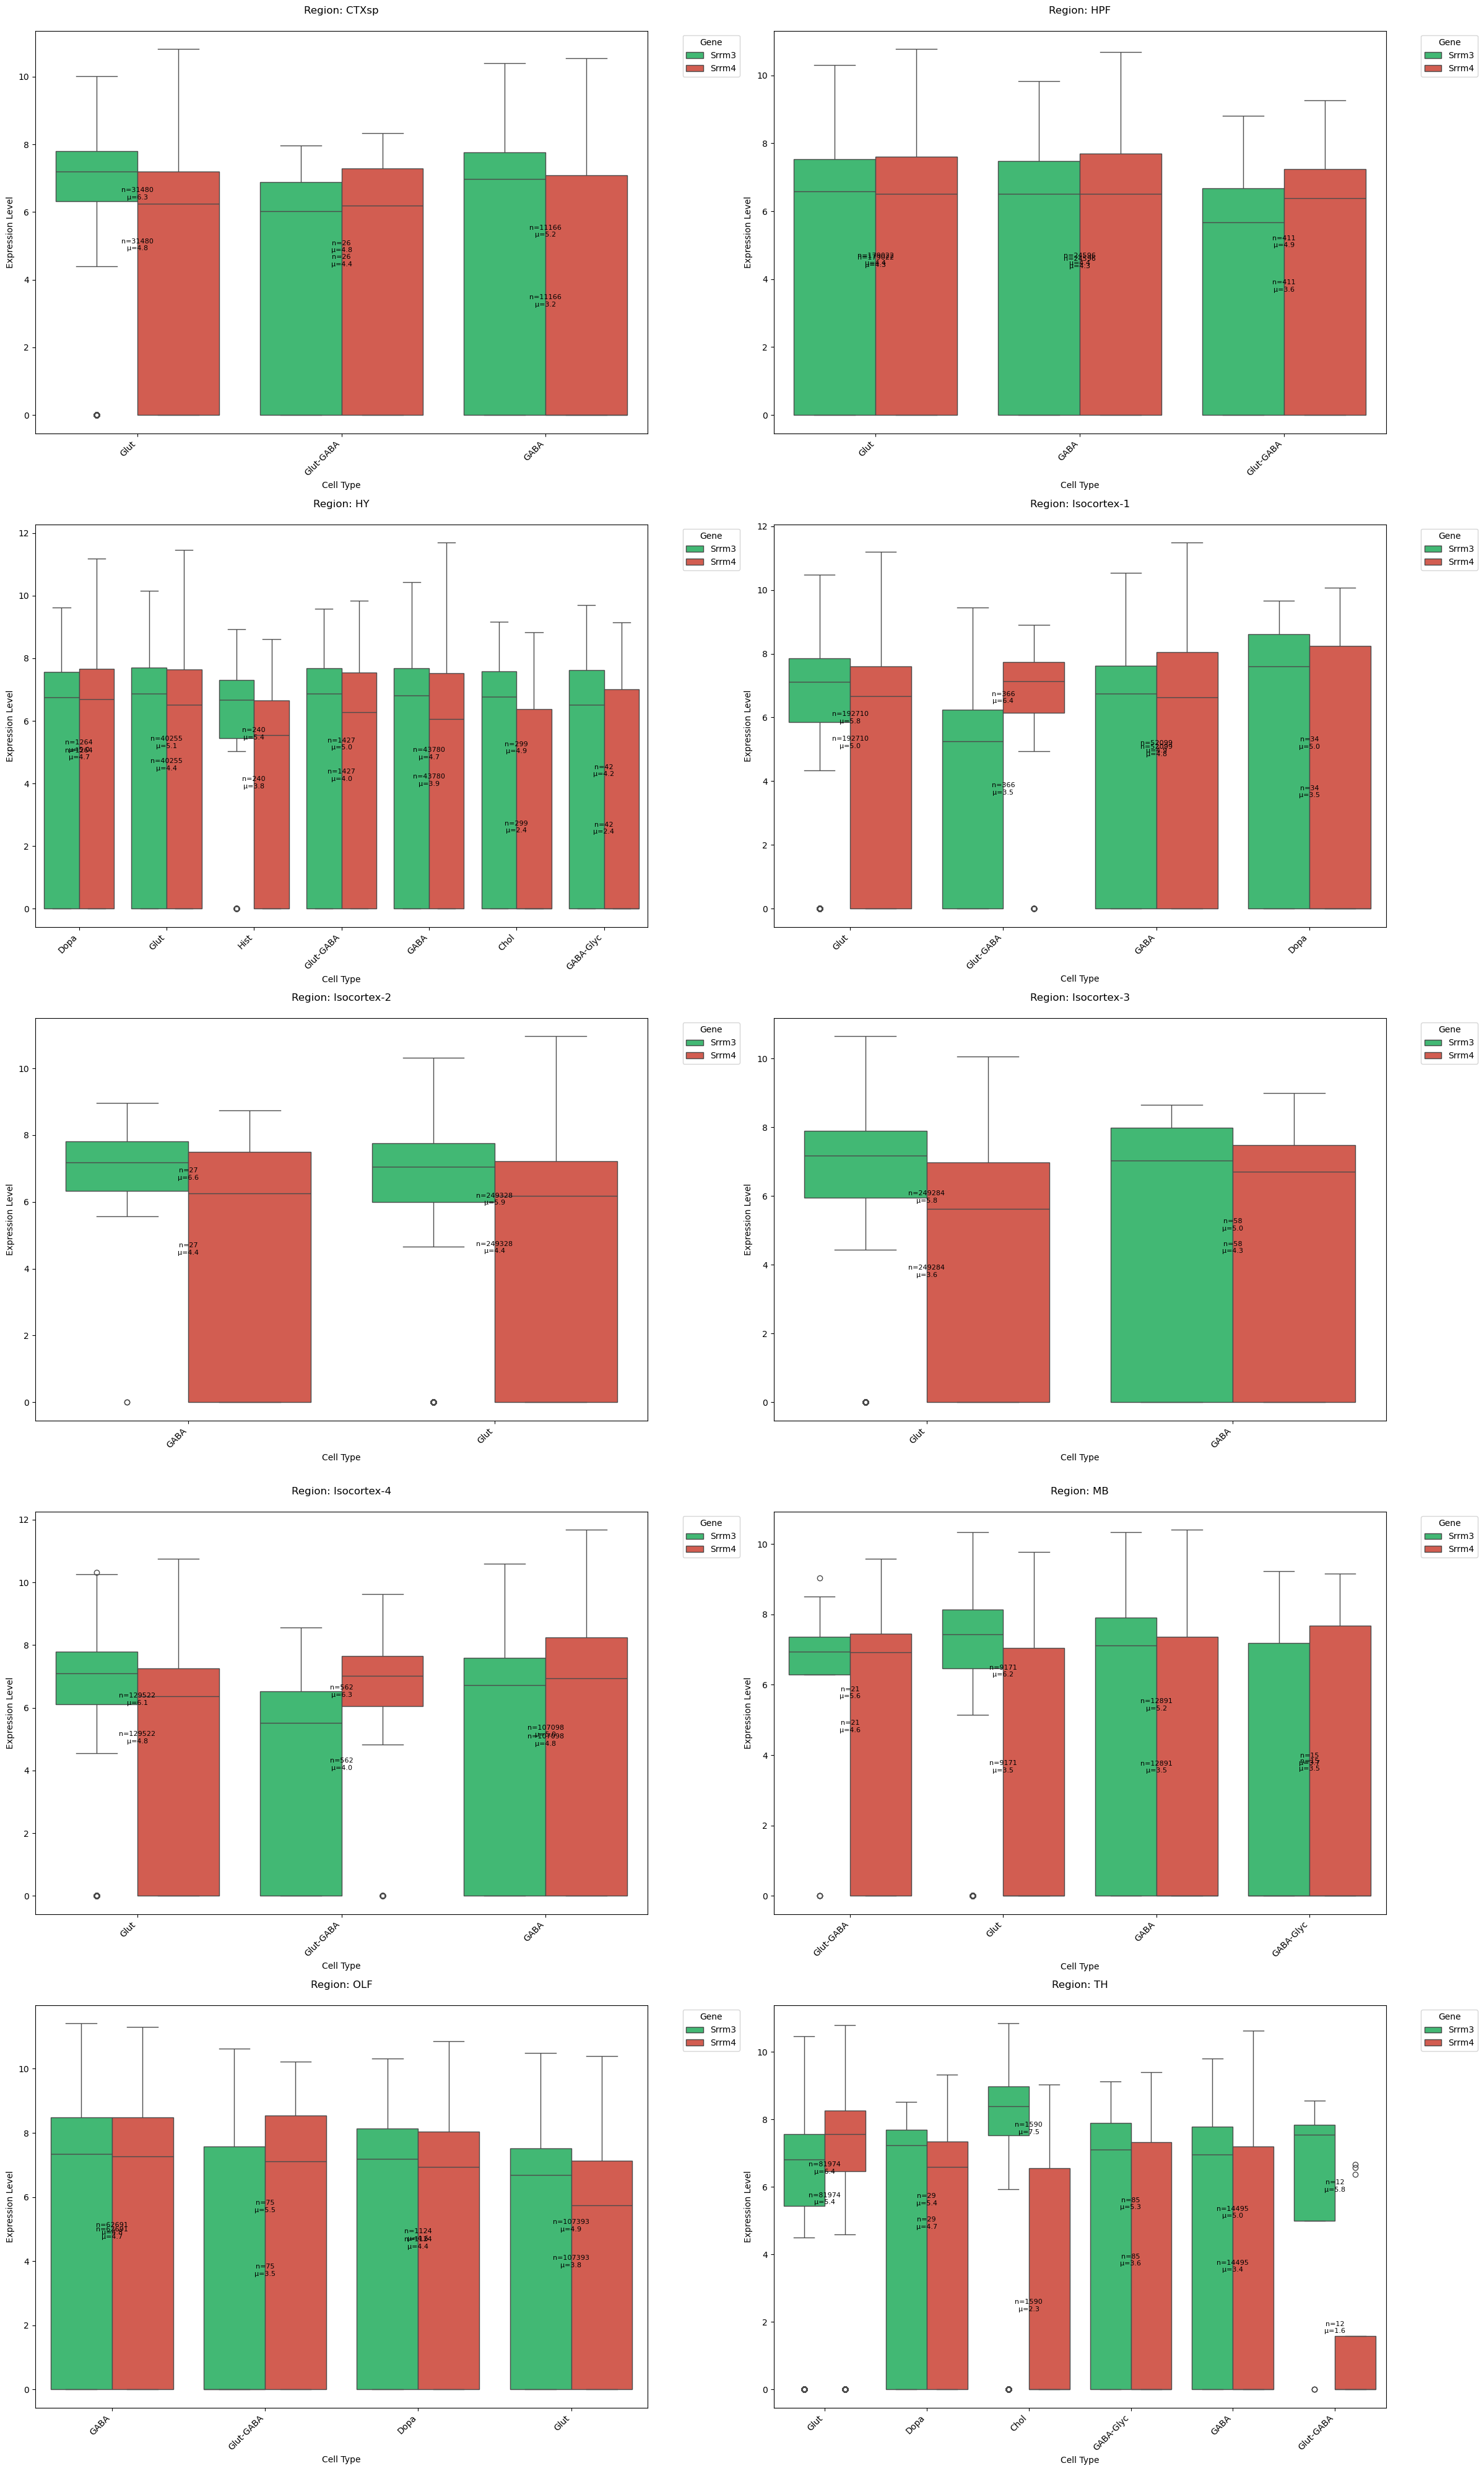

In [20]:
def plot_region_gene_comparison(expression_data: pd.DataFrame, 
                              metadata: pd.DataFrame,
                              genes: List[str],
                              group_by: str = 'neurotransmitter_label',  # Changed to neurotransmitter_label
                              figsize: Tuple[int, int] = (15, 10),
                              min_cells: int = 10):  # Added minimum cells threshold
    """
    Create separate plots for each brain region with side-by-side gene comparisons
    using broader cell type classifications
    """
    # Prepare the data
    plot_data = pd.DataFrame({
        'Expression': pd.concat([expression_data[gene] for gene in genes]),
        'Gene': np.repeat(genes, len(expression_data)),
        'Group': pd.concat([metadata[group_by] for _ in genes]),
        'Region': pd.concat([expression_data['region'] for _ in genes])
    })
    
    # Count cells in each group for filtering
    group_counts = plot_data.groupby(['Region', 'Group', 'Gene']).size().reset_index(name='count')
    valid_groups = group_counts[group_counts['count'] >= min_cells][['Region', 'Group']].drop_duplicates()
    
    # Filter data to include only groups with sufficient cells
    plot_data = plot_data.merge(valid_groups, on=['Region', 'Group'])
    
    # Get unique regions
    regions = sorted(plot_data['Region'].unique())
    
    # Create a figure with subplots for each region
    n_regions = len(regions)
    n_cols = 2
    n_rows = (n_regions + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize[0]*n_cols, figsize[1]*n_rows))
    if n_regions == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    # Plot for each region
    for idx, region in enumerate(regions):
        if idx < len(axes):
            ax = axes[idx]
            region_data = plot_data[plot_data['Region'] == region]
            
            # Calculate mean expression for sorting
            mean_expr = region_data.groupby(['Group', 'Gene'])['Expression'].mean().reset_index()
            mean_expr_pivot = mean_expr.pivot(index='Group', columns='Gene', values='Expression')
            mean_expr_sum = mean_expr_pivot.sum(axis=1)
            
            # Get groups ordered by expression
            ordered_groups = mean_expr_sum.sort_values(ascending=False).index
            
            # Create the box plot
            sns.boxplot(data=region_data, 
                       x='Group', 
                       y='Expression',
                       hue='Gene',
                       order=ordered_groups,
                       palette=['#2ecc71', '#e74c3c'],  # Green for Srrm3, Red for Srrm4
                       ax=ax)
            
            # Customize the plot
            ax.set_title(f'Region: {region}', fontsize=12, pad=20)
            ax.set_xlabel('Cell Type', fontsize=10)
            ax.set_ylabel('Expression Level', fontsize=10)
            
            # Rotate x-axis labels
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
            
            # Add number of cells for each group
            for i, group in enumerate(ordered_groups):
                for j, gene in enumerate(genes):
                    group_data = region_data[
                        (region_data['Group'] == group) & 
                        (region_data['Gene'] == gene)
                    ]
                    n_cells = len(group_data)
                    mean_val = group_data['Expression'].mean()
                    ax.text(i, mean_val, f'n={n_cells}\nμ={mean_val:.1f}', 
                           ha='center', va='bottom', fontsize=8)
            
            # Adjust legend
            ax.legend(title='Gene', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Remove empty subplots if any
    for idx in range(len(regions), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    
    # Print statistical summary
    print("\nStatistical Summary:")
    for region in regions:
        print(f"\nRegion: {region}")
        region_data = plot_data[plot_data['Region'] == region]
        for group in ordered_groups:
            print(f"\n{group}:")
            group_data = region_data[region_data['Group'] == group]
            for gene in genes:
                gene_data = group_data[group_data['Gene'] == gene]
                print(f"  {gene}: n={len(gene_data)}, "
                      f"mean={gene_data['Expression'].mean():.2f}, "
                      f"median={gene_data['Expression'].median():.2f}, "
                      f"std={gene_data['Expression'].std():.2f}")
    
    return fig, axes

# Create visualizations
print("Creating region-specific box plots with aggregated cell types...")
fig, axes = plot_region_gene_comparison(
    expression_data,
    metadata,
    genes=['Srrm3', 'Srrm4'],
    group_by='neurotransmitter_label',  # Using broader classification
    figsize=(12, 8),
    min_cells=10  # Only show groups with at least 10 cells
)
plt.show()

# # Optionally, try with subclass_label
# print("\nAlternative visualization using subclass classification...")
# fig, axes = plot_region_gene_comparison(
#     expression_data,
#     metadata,
#     genes=['Srrm3', 'Srrm4'],
#     group_by='subclass_label',
#     figsize=(12, 8),
#     min_cells=10
# )
# plt.show()

In [ ]:
print("\nCreating dimension reduction plots...")
fig, _ = create_dimension_reduction_plot(
    expression_data,
    metadata,
    method='umap',
    color_by=['class_label', 'neurotransmitter_label', 'region'],
    genes=genes
)
plt.show()

# Legacy

In [ ]:
def plot_region_gene_comparison(expression_data: pd.DataFrame, 
                              metadata: pd.DataFrame,
                              genes: List[str],
                              group_by: str = 'neurotransmitter_label',  # Changed to neurotransmitter_label
                              figsize: Tuple[int, int] = (15, 10),
                              min_cells: int = 10):  # Added minimum cells threshold
    """
    Create separate plots for each brain region with side-by-side gene comparisons
    using broader cell type classifications
    """
    # Prepare the data
    plot_data = pd.DataFrame({
        'Expression': pd.concat([expression_data[gene] for gene in genes]),
        'Gene': np.repeat(genes, len(expression_data)),
        'Group': pd.concat([metadata[group_by] for _ in genes]),
        'Region': pd.concat([expression_data['region'] for _ in genes])
    })
    
    # Count cells in each group for filtering
    group_counts = plot_data.groupby(['Region', 'Group', 'Gene']).size().reset_index(name='count')
    valid_groups = group_counts[group_counts['count'] >= min_cells][['Region', 'Group']].drop_duplicates()
    
    # Filter data to include only groups with sufficient cells
    plot_data = plot_data.merge(valid_groups, on=['Region', 'Group'])
    
    # Get unique regions
    regions = sorted(plot_data['Region'].unique())
    
    # Create a figure with subplots for each region
    n_regions = len(regions)
    n_cols = 2
    n_rows = (n_regions + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize[0]*n_cols, figsize[1]*n_rows))
    if n_regions == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    # Plot for each region
    for idx, region in enumerate(regions):
        if idx < len(axes):
            ax = axes[idx]
            region_data = plot_data[plot_data['Region'] == region]
            
            # Calculate mean expression for sorting
            mean_expr = region_data.groupby(['Group', 'Gene'])['Expression'].mean().reset_index()
            mean_expr_pivot = mean_expr.pivot(index='Group', columns='Gene', values='Expression')
            mean_expr_sum = mean_expr_pivot.sum(axis=1)
            
            # Get groups ordered by expression
            ordered_groups = mean_expr_sum.sort_values(ascending=False).index
            
            # Create the box plot
            sns.boxplot(data=region_data, 
                       x='Group', 
                       y='Expression',
                       hue='Gene',
                       order=ordered_groups,
                       palette=['#2ecc71', '#e74c3c'],  # Green for Srrm3, Red for Srrm4
                       ax=ax)
            
            # Customize the plot
            ax.set_title(f'Region: {region}', fontsize=12, pad=20)
            ax.set_xlabel('Cell Type', fontsize=10)
            ax.set_ylabel('Expression Level', fontsize=10)
            
            # Rotate x-axis labels
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
            
            # Add number of cells for each group
            for i, group in enumerate(ordered_groups):
                for j, gene in enumerate(genes):
                    group_data = region_data[
                        (region_data['Group'] == group) & 
                        (region_data['Gene'] == gene)
                    ]
                    n_cells = len(group_data)
                    mean_val = group_data['Expression'].mean()
                    ax.text(i, mean_val, f'n={n_cells}\nμ={mean_val:.1f}', 
                           ha='center', va='bottom', fontsize=8)
            
            # Adjust legend
            ax.legend(title='Gene', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Remove empty subplots if any
    for idx in range(len(regions), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    
    # Print statistical summary
    print("\nStatistical Summary:")
    for region in regions:
        print(f"\nRegion: {region}")
        region_data = plot_data[plot_data['Region'] == region]
        for group in ordered_groups:
            print(f"\n{group}:")
            group_data = region_data[region_data['Group'] == group]
            for gene in genes:
                gene_data = group_data[group_data['Gene'] == gene]
                print(f"  {gene}: n={len(gene_data)}, "
                      f"mean={gene_data['Expression'].mean():.2f}, "
                      f"median={gene_data['Expression'].median():.2f}, "
                      f"std={gene_data['Expression'].std():.2f}")
    
    return fig, axes

# Create visualizations
print("Creating region-specific box plots with aggregated cell types...")
fig, axes = plot_region_gene_comparison(
    expression_data,
    metadata,
    genes=['Srrm3', 'Srrm4'],
    group_by='neurotransmitter_label',  # Using broader classification
    figsize=(12, 8),
    min_cells=10  # Only show groups with at least 10 cells
)
plt.show()

# Optionally, try with subclass_label
print("\nAlternative visualization using subclass classification...")
fig, axes = plot_region_gene_comparison(
    expression_data,
    metadata,
    genes=['Srrm3', 'Srrm4'],
    group_by='subclass_label',
    figsize=(12, 8),
    min_cells=10
)
plt.show()

In [ ]:
# Calculate and display summary statistics
print("\nSummary statistics by region and cell class:")
for gene in genes:
    print(f"\n{gene} expression summary:")
    summary = pd.DataFrame({
        'Expression': expression_data[gene],
        'Region': expression_data['region'],
        'Class': metadata['class_label']
    }).groupby(['Region', 'Class']).agg({
        'Expression': ['mean', 'std', 'count']
    }).round(2)
    
    print(summary.sort_values(('Expression', 'mean'), ascending=False).head(10))
    
# Add correlation analysis
correlation = expression_data[genes].corr()
print("\nCorrelation between Srrm3 and Srrm4:")
print(correlation)
